In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from scipy.special import softmax

In [3]:
from scipy.optimize import minimize

In [4]:
from sklearn.utils import shuffle

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [7]:
class MixtureExpert:
    def __init__(self, n = 10, K = 2, beta = 1):
        self.K = K
        self.n = n
        
        self.beta = beta
        self.W = 0.001*np.random.randn(self.K, self.n)
        self.V = 0.001*np.random.randn(self.K, self.n)
        self.pZ = None
        
        self.state = dict()
       
    def dFdV(self, X):
        N = X.shape[0]
        grad = np.zeros_like(self.V)
        Temp = softmax(X@self.V.T, axis = 1)
        for i in range(N):
            x = X[i]
            temp = Temp[i]
            grad += (np.reshape(self.pZ[i], [-1, 1])@np.reshape(x, [1, -1]) - np.reshape(temp, [-1, 1])@np.reshape(x, [1, -1]))
        return grad
        
    def E_step(self, X, Y):
        N = X.shape[0]
        self.pZ = np.zeros([N, self.K])
        for i in range(N):
            x = X[i]
            y = Y[i]
            self.pZ[i] = softmax(self.V@x - 0.5*self.beta*((y - self.W@x)**2), axis=0)
    
    def M_step(self, X, Y):
        N = X.shape[0]
# Optimize W
        for k in range(self.K):
            temp1 = 0
            temp2 = 0
            for i in range(N):
                x = X[i]
                y = Y[i]
                z = self.pZ[i][k]
                temp1 += np.reshape(x, [-1, 1])@np.reshape(x, [1, -1])*z
                temp2 += y*z*x
            self.W[k] = np.reshape(np.linalg.inv(temp1)@np.reshape(temp2, [-1, 1]), [-1])

# Optimize \beta
        param_state = self.state['beta']
        temp = 0
        for i in range(N):
            x = X[i]
            y = Y[i]
            z = self.pZ[i]
            temp += (((y - self.W@x)**2)*z).sum()
        self.beta = N/(temp+param_state['epsilon'])
            
# Optimize V
        param_state = self.state['V']
        alpha = param_state['alpha']
        momentum = param_state['momentum']
        dampening = param_state['dampening']
        for _ in range(100):
            grad = self.dFdV(X)
            if momentum != 0:
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = np.array(grad)
                else:
                    param_state['momentum_buffer'] = momentum*param_state['momentum_buffer'] + (1 - dampening)*grad
                grad = param_state['momentum_buffer']
            self.V += alpha*grad
        
        

    def fit(self, X = None, Y = None, epoch = 10, epsilon = 0.00001, alpha = 0.01, momentum = 0, dampening = 0):
        """
        X has a shape [N x n]
        Y has a shape [n]
        """
        if X is None:
            return None
        if y is None:
            return None
        
        if 'V' not in self.state:
            self.state['V'] = dict()
        if 'W' not in self.state:
            self.state['W'] = dict()
        if 'beta' not in self.state:
            self.state['beta'] = dict()
        self.state['V']['alpha'] = alpha
        self.state['V']['momentum'] = momentum
        self.state['V']['dampening'] = dampening
        
        self.state['beta']['epsilon'] = epsilon
        
        for _ in range(epoch):
            self.E_step(X, Y)
            self.M_step(X, Y)
            
        return
    
    def predict(self, X):
        """
        X has a shape [N x n]
        """
        pi = softmax(X@self.V.T, axis = 1)
        
        answ = (X@self.W.T) 
        
        return (answ*pi).sum(axis = 1)

In [8]:
# def func(x):
#     if np.round(x)%2 == 0:
#         return -x
#     else:
#         return x

# N = 1000
# n = 1
# x = np.linspace(-10, 10, N)
# y = np.array(list(map(func, x))) + 0.1*np.random.randn(N)
# x, y = shuffle(x, y)

# X = np.reshape(x, [-1, 1])
# Y = y

In [9]:
N = 500
n = 3
r1 = 1
r2 = 2
phi = np.linspace(0, 2*np.pi, N)
x = np.hstack([r1*np.sin(phi), r2*np.sin(phi)])
y = np.hstack([r1*np.cos(phi), r2*np.cos(phi)])
x, y = shuffle(x, y)

X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
Y = x**2+y**2

In [10]:
X.shape, Y.shape

((1000, 3), (1000,))

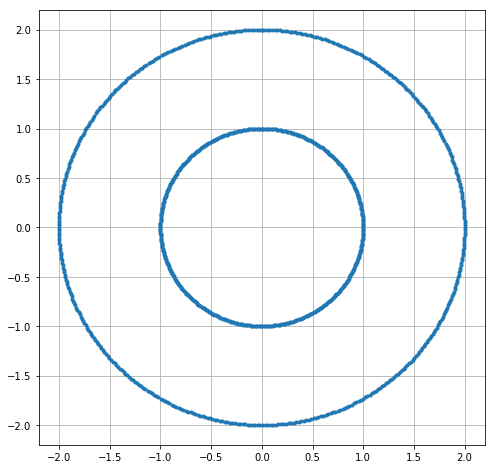

In [11]:
_ = plt.plot(x, y, '.')

plt.grid()
plt.show()

In [12]:
model = MixtureExpert(n = n, K = 2, beta = 1)

In [13]:
model.fit(X, Y, epoch = 10, alpha = 0.1, momentum = 0.99)

In [14]:
answ = model.predict(X)

In [15]:
((answ - Y)**2).mean()

1.5734961551627986

In [16]:
model.W

array([[-0.83376536, -0.34630454,  0.61227244],
       [ 0.5100008 ,  0.21331758,  1.53827713]])

In [17]:
model.V

array([[-14588.32324467,  -5971.14012105,  -9618.71016261],
       [ 14588.3231264 ,   5971.14031577,   9618.70775857]])

In [18]:
model.beta

0.6355274465486469

In [19]:
model.dFdV(X)

array([[ 2.97910814e-12, -4.95375038e-12, -1.44513685e-12],
       [-2.97717406e-12,  4.95070651e-12,  1.44417811e-12]])

In [20]:
pi = softmax(X@model.V.T, axis = 1)

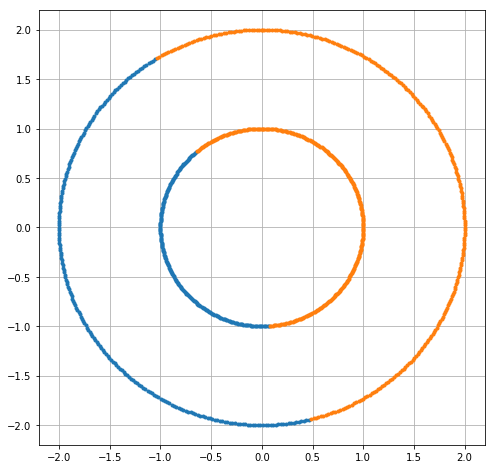

In [21]:
idx = np.argmax(model.pZ, axis = 1)
for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.')

plt.grid()
plt.show()